#### This notebook is post-processing curvature points to extract the approximate location of the corners.

The information extracted from the curvature are noisy. The goal is too group the noisy points into regions, where approximately the corners are.

In [1]:
import pandas as pd
import numpy as np

In [2]:
points = pd.read_csv("/Users/valentina/projects/cornea_project/Lepto/processed/thesholded_curvature.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# old version 0.04 - 0.05
# 0.037 - 0.05 cannot finish in spectral clustering
points.Gauss_Curvature.max()
points_subset = points[points['Gauss_Curvature'].between(0.04,0.05)]
points_subset.shape

(1916, 7)

### K Means clustering

In [5]:
from sklearn.cluster import KMeans
X = points_subset[["Points:0","Points:1","Points:2"]]
kmeans = KMeans(n_clusters = 200,random_state=0).fit(X)
labels = kmeans.labels_
labels.astype(np.float)
print(len(labels))

1916


In [6]:
points.columns

Index(['Normals:0', 'Normals:1', 'Normals:2', 'Gauss_Curvature', 'Points:0',
       'Points:1', 'Points:2'],
      dtype='object')

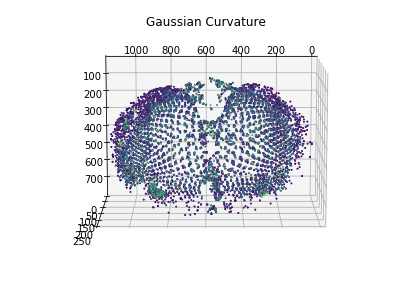

In [7]:
# plot the points covered by curvature
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points["Points:0"], points["Points:1"],points["Points:2"], c=np.array(points["Gauss_Curvature"]), s=0.5, cmap='viridis')
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.title('Gaussian Curvature')
plt.show()

In [8]:
# unnecessary colormap stuff
#
cmap = plt.get_cmap('rainbow',len(set(labels)))
colors = [cmap(l) for l in labels]
np.array(colors).shape
colors = [int(i % 23) for i in labels]
labels.astype(np.float)


import matplotlib as mpl

N = 200
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
(labels).astype(np.int)
print(len(labels))

labels.shape


1916


(1916,)

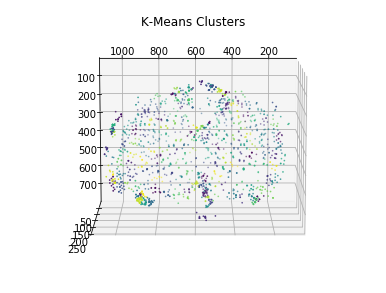

In [9]:
# kmeans clustering
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(points_subset["Points:0"]), np.array(points_subset["Points:1"]),np.array(points_subset["Points:2"]), c=labels, s=0.5,cmap = "viridis")
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.title('K-Means Clusters')
plt.show()

# colormap does not work: keeping getting invalid RGBA error

In [10]:
#kmeans.cluster_centers_

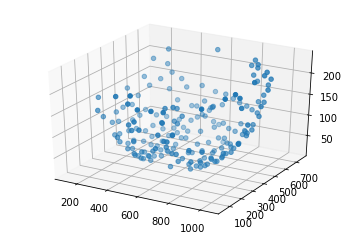

In [11]:
# plot the centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2])

### Nearest Neighbor Graph and Spectral Clustering

In [12]:
# finding the nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [13]:
# creating the nearest neighbor graph
G = nbrs.kneighbors_graph(X, mode='distance').toarray()

In [14]:
G.shape

(1916, 1916)

In [15]:
# spectral clustering
from sklearn import cluster
spectral = cluster.SpectralClustering(n_clusters=20, eigen_solver='arpack',affinity="nearest_neighbors")
spectral.fit(X)

/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=20, n_init=10,
          n_jobs=1, n_neighbors=10, random_state=None)

In [16]:
labels = spectral.labels_

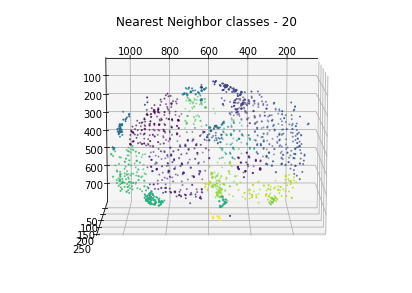

In [17]:
# create colors for the visualization
from itertools import cycle, islice
spectral.labels_
y_pred = spectral.labels_.astype(np.int)
# colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
#                                             '#f781bf', '#a65628', '#984ea3',
#                                             '#999999', '#e41a1c', '#dede00']),
#                                      int(max(y_pred) + 1))))
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_subset["Points:0"], points_subset["Points:1"],points_subset["Points:2"], s=1, c=spectral.labels_)
ax.view_init(100, 90)
plt.title("Nearest Neighbor classes - 20")
plt.show()

In [18]:
# from sklearn.neighbors import RadiusNeighborsClassifier
# radius_nbrs = RadiusNeighborsClassifier(radius=1.0)
# radius_nbrs.radius_neighbors_graph(X)

#### Radius Nearest Neighbors

The radius nearest neighbors might be a better choice in this case. 

In [19]:
from sklearn.neighbors import radius_neighbors_graph
G = radius_neighbors_graph(X,5,mode='connectivity',include_self=True)
print(G.shape)
G.toarray()

(1916, 1916)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

The connectivity matrix is big but mainly contains zeros and ones. Spectral Clustering has different methods to solve the linear algebra problem:
* it can accept a precomputed sparse matrix
* default 'arpack'
* the 'amg' method is supposed to work well with large and sparse but requires pyamg package installed sometimes returns a numerical error

In [20]:
# If you do not have pyamg installed, uncomment next two cells

In [21]:
# !conda install --yes pyamg

In [22]:
# import pyamg

In [24]:
%%time
from scipy import sparse
G_sparse = sparse.csr_matrix(G.toarray())
spectral_radius = cluster.SpectralClustering(n_clusters=200, eigen_solver='arpack',affinity='precomputed')
labels = spectral_radius.fit_predict(G)
#labels = spectral_radius.labels_

/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

#### Visualization with Plotly

In [25]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

In [26]:
# plotly requires the notebook 
%matplotlib notebook

In [27]:
# creating a colormap which can distinguish separate clusters
num = 200
x3 = np.linspace(-0.5,1,num) + (0.5 - np.random.rand(num))

In [28]:
trace_curv = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=points['Gauss_Curvature'].astype(np.float),
                                colorscale='Viridis',
                                line=dict(color='black', width=1)))

In [29]:
trace_clust = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=labels.astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [30]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])

In [31]:
scene = dict(
    aspectmode = 'data',
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=2.5)
    ),
    xaxis=dict(
        range=[0, 1000],
        title='x',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(
        range=[0, 1000],
        title='y',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(
        range=[1,200],
        title='z',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

In [32]:
#fig = go.Figure(data=data, layout=layout)
fig.append_trace(trace_curv,1,1)
fig['layout'].update(title = "Gaussian Curvature")
fig['layout']['scene1'].update(scene)

In [35]:
py.iplot(fig,filename='clustering')

In [36]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_clust,1,1)
fig['layout'].update(title = "Clustering")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='clustering')

In [37]:
## dbscan
from sklearn.cluster import DBSCAN

In [44]:
db = DBSCAN(eps=10, min_samples=2).fit(X)

In [45]:
labels = db.labels_

In [46]:
len(labels)

1916

In [47]:
trace_clust = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=labels.astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [48]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_clust,1,1)
fig['layout'].update(title = "DBScan Clustering")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='clustering')